In [1]:
import numpy as np
from skimage import io
from collections import defaultdict
import cv2
import pandas as pd
import os
from tqdm import tqdm
import math
import warnings
warnings.filterwarnings('ignore')

with open('image.txt','r') as f:
    filename = f.readlines()

filename = [_.split('\n')[0] for _ in filename]

def getline(img):
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    grad = cv2.morphologyEx(imgray, cv2.MORPH_GRADIENT, kernel)

    _, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
    connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
    # using RETR_EXTERNAL instead of RETR_CCOMP
    contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    mask = np.zeros(bw.shape, dtype=np.uint8)
    for idx in range(len(contours)):
        x, y, w, h = cv2.boundingRect(contours[idx])
        mask[y:y+h, x:x+w] = 0
        cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
        r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)
        if r > 0.2 and w > 8 and h > 8:
            mask[y:y+h, x:x+w] = 255

    dst = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
    return dst , mask


def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.lstsq(A, b)[0]
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections


C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
all_data = pd.DataFrame()

for _ in os.listdir('csv'):
    da = pd.read_csv('csv/' + _ ,encoding='CP949')
    all_data = pd.concat([all_data,da])
    
all_data.reset_index(drop=True, inplace=True)

all_data1 = all_data.copy()
other = all_data1[all_data1['cctvname'].str.contains('중부3터널|길마재교|동탄금곡교|광교터널|동시흥|판교외부1|공릉천교|남광명|기흥동탄|금이3|판교나들목|청계산2-3터널|청계산3-4터널') & (all_data1['강수15']>0)]
all_data1 = all_data1[all_data1['cctvname'].str.contains('서울문산선|부곡|독정2|논현교|포도|만정교|신길교|청사4R\(상행\)|청사입구|하산곡|상적|상산곡|금현|갈매|강문|현곡|음섬|원곡|파장육교|안성분기|장덕교|고덕|과천대로|갈현|별양로|과천성당|남양|학익|제2경인시점|총신교|민마루|중랑|제2영동|광주분기|금곡교|조암|죽전|부천|도당|부평|강일|미사|덕소1교|삼패|선암|군포|둔대|반월|원지동|시화|화정|원동|상리교|이목동|대공원|문원|남태령|굴다리|부림교|청사IC|신월|월문1교|통신부대|월문1터널|평택화성선|남구리|제2외곽순환선|외동천교|달래내|서해안선|기흥|오산|제2순환선|인천국제공항|용인서울선|안산천|안양성남선|광명|수도권제1순환선|금천|경마장|금토분기점1|졸음|정류장|부산|동탄|터널|영업소|공세육교|판교|도당|청천교|효성|하차도|우정병원|인덕원|남구리|우면산|용암천|노하1교|고잔|고가교|조남|홍원|동판교|삼막|여수|광교|군자|동백교|구성|동수원|기흥교|서창|신갈|거모|야목|창현|화도|양지|용인|월곶|하강교|신천|은행|안현분기점1|일직|광지원교|초월|하남|안녕|청북|해창교|평택분기|진위천|토진2교|청룡교|안화2교|궁리|고념1교|용포1교|주곡1교|시길천교|장덕1교|송산마도|서평택|석교교|군자|초월|동서울|늑현|진우|선동|학운|궁평|석수|문학|남인천|남동|서안산|강릉|안성휴게|부곡1교|매송휴게|목감') == 0]
all_data1 = all_data1[all_data1['강수15'] < 5]
all_data1.loc[all_data1['강수15'] >2.5,'강수15'] = 2.5
dense = all_data1[(all_data1['fog'] == 'Dense')]
all_data1 = all_data1[(all_data1['fog'] != 'Dense')]
rain = all_data1[all_data1['강수15'] > 0.5]
all_data1 = all_data1[all_data1['강수15'] <= 0.5]

rain1 = all_data1[all_data1['강수15'] == 0.5]
all_data1 = all_data1[all_data1['강수15'] == 0]
all_data2 = all_data1.sample(600,random_state=0)

total = pd.concat([dense, rain, rain1, other, all_data2],axis=0).reset_index(drop=True)
total.loc[total['강수15'] >2.5,'강수15'] = 2.5

In [5]:
all_data1['cctvname'].unique()

array(['[경부선] 금토분기점2', '[경부선] 백현', '[영동선] 북수원', '[영동선] 파장동',
       '[영동선] 안산분기점', '[영동선] 안산', '[영동선] 양상교', '[영동선] 안산2',
       '[평택시흥선] 고정2교', '[평택시흥선] 공룡알화석지', '[평택시흥선] 신길천교', '[경부선] 수원',
       '[경부선] 남사육교', '[영동선] 조원교', '[경부선] 산하', '[영동선] 마성', '[영동선] 마성3',
       '[영동선] 마성1', '[영동선] 마성2', '[평택제천선] 송탄', '[평택시흥선] 청원교',
       '[평택시흥선] 정든교', '[평택시흥선] 수촌1교', '[평택시흥선] 금의1육교', '[과천시] 청사4R(하행)',
       '[과천시] 소방서3R(하행)', '[과천시] 시청4R(소방서3R(경찰서))', '[과천시] 도서관3R(중앙로)',
       '[중부선] 천현', '[구리포천선] 별내2교', '[구리포천선] 남별내IC', '[경부선] 서초',
       '[경부선] 양재', '[구리포천선] 옥정IC', '[구리포천선] 양주IC', '[구리포천선] 별내휴게소',
       '[평택시흥선] 남안산', '[제2경인선] 안현분기점2', '[영동선] 논현육교', '[경인선] 서운분기점2',
       '[경인선] 가정동', '[영동선] 추계육교', '[중부선] 곤지암', '[중부선] 광주', '[중부선] 광지원2교',
       '[중부선] 산곡분기점', '[제2중부선] 천진암교', '[제2중부선] 하번천', '[제2중부선] 엄미교',
       '[서울양양선] 차산리', '[구리포천선] 동의정부IC북측', '[구리포천선] 의정부휴게소(구리)',
       '[구리포천선] 민락IC'], dtype=object)

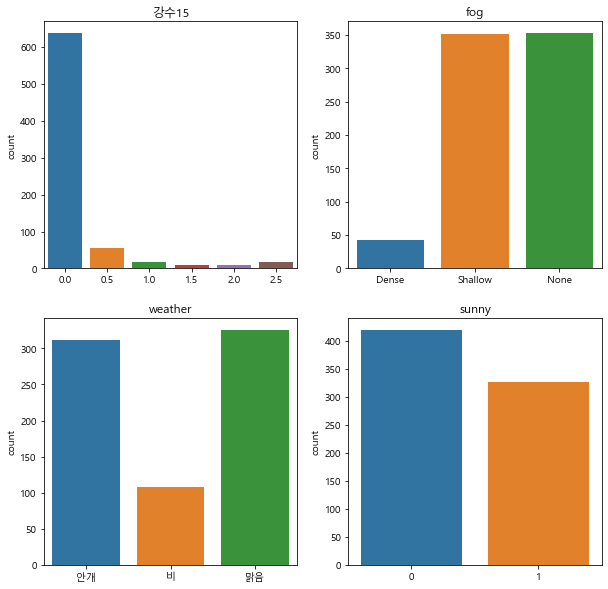

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()

rc('font', family=font_name)
label_col = all_data.columns[3:7]
plt.figure(figsize = (10,10))
for _ , i in enumerate(label_col):
    plt.subplot(2,2, _+1)
    sns.countplot(x = i ,data=total)
    plt.title(i)
    plt.xlabel('')

In [16]:
total.head()

,cctvname,coordy,coordx,강수15,fog,weather,sunny,AWS distance,ASOS distance,cctvdir
0,[영동선] 추계육교,37.248890,127.32417,0.0,Dense,안개,0,0.001469,0.002239,video/2020102707/[영동선] 추계육교.mp4
1,[중부선] 곤지암,37.352330,127.32107,0.0,Dense,안개,0,0.001631,0.002740,video/2020102707/[중부선] 곤지암.mp4
2,[중부선] 광주,37.448097,127.26929,0.0,Dense,안개,0,0.000264,0.003199,video/2020102707/[중부선] 광주.mp4
3,[중부선] 광지원2교,37.453230,127.25556,0.0,Dense,안개,0,0.000317,0.003367,video/2020102707/[중부선] 광지원2교.mp4
4,[중부선] 산곡분기점,37.479763,127.24332,0.0,Dense,안개,0,0.000807,0.003482,video/2020102707/[중부선] 산곡분기점.mp4


In [7]:
total['강수15'].value_counts()

0.0    638
0.5     56
2.5     18
1.0     18
1.5      8
2.0      8
Name: 강수15, dtype: int64

In [112]:
from sklearn.cluster import KMeans
K = 4
thresh_type = cv2.THRESH_BINARY_INV
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)
video = []
label = []
roi6 = []

for i in tqdm(range(total.shape[0])):
    count = 0
    pattern = []
    rr = []
    videoFile = total['cctvdir'][i]
    if not os.path.isfile(videoFile):
        continue

    cap = cv2.VideoCapture(videoFile)
    frameRate = cap.get(5)
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break        
        if (frameId % math.floor(frameRate/12) == 0):
            if count == 0:
                img, mask = getline(frame)
                Z = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                Z = Z.reshape((-1,3))

                Z = np.float32(Z)

                ret,seg_label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_PP_CENTERS)

                center = np.uint8(center)

                res = center[seg_label.flatten()]
                result_image = res.reshape((img.shape))
                dst1 = result_image.copy()
                imgray = cv2.cvtColor(dst1, cv2.COLOR_RGB2GRAY)
                blur = cv2.medianBlur(imgray, 3)
                adapt_type = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
                bin_img = cv2.adaptiveThreshold(blur, 255, adapt_type, thresh_type, 7, 2)

                lines = None
                hough_threshold = 200

                while(not np.all(np.not_equal(lines, None))):
                    lines = cv2.HoughLines(bin_img,1,np.pi/180,hough_threshold)
                    hough_threshold-=10
                    if hough_threshold < 0:
                        break
                if hough_threshold < 0:
                    break

                if len(lines) == 1:
                    lines = cv2.HoughLines(bin_img,1,np.pi/180,hough_threshold)
                xy_line = []

                for line in lines:
                    r, theta = line[0]
                    a = np.cos(theta)
                    b = np.sin(theta)
                    x0 = a*r
                    y0 = b*r
                    x1 = int(x0 + 1000*(-b))
                    y1 = int(y0 + 1000*a)
                    x2 = int(x0 - 1000*(-b))
                    y2 = int(y0 - 1000*a)
                    xy_line.append([x1,y1,x2,y2])

                segmented = segment_by_angle_kmeans(lines)
                intersections = segmented_intersections(segmented)

                if not intersections:
                    cen = [160,120]
                else:
                    inters = np.array(intersections)
                    inters = inters.reshape(inters.shape[0],-1)
                    inters = inters[(inters[:,0]<320) & (inters[:,1]<240) & (inters[:,0] > 0)  & (inters[:,1] > 0) ]
                    if len(inters) > 1:
                        clf = KMeans(n_clusters=2)
                        clf.fit(inters)
                        labels = clf.labels_
                        cen = list()

                        for _ in np.unique(labels):
                            cell = inters[labels == _ ]
                            cell = np.mean(cell,axis=0).astype('int')
                            cen.append(cell)

                        cen = np.array(cen).mean(axis=0).astype('int')
    #                     cen = inters.reshape(inters.shape[2])
                    else:
                        cen = [160,120]
            
                label_img = seg_label.reshape((result_image.shape[:2]))
                lab = np.argmin(np.mean(center, axis=1))
                t= np.arange(-np.pi,np.pi, 0.1)
                x= 1000*np.sin(t)
                y= 1000*np.cos(t)
                a = y/x
                b = y - a*x
                k = []


                dst2 = img.copy()

                for a1,b1 in zip(a,b):

                    i_r = np.arange(0,240)
                    i_c = np.array([(num - cen[1] - b1)/a1 + cen[0] for num in i_r])
                    i_r = i_r[np.where((i_c > 0) & (i_c < 320))]
                    i_c = i_c[np.where((i_c > 0) & (i_c < 320))]
                    k.append(np.sum([label_img[int(r),int(c)] == lab  for r,c in zip(i_r, i_c)]))

                k = np.array(k)
                inde = np.argmax(k)
                i_r = np.arange(0,320)
                i_c = np.array([a[inde]*(num - cen[0]) +b[inde]+ cen[1] for num in i_r])
                i_r = i_r[np.where((i_c > 0) & (i_c < 240))]
                i_c = i_c[np.where((i_c > 0) & (i_c < 240))]
                random_sam = i_r[[label_img[int(c),int(r)] == lab  for r,c in zip(i_r, i_c)]]
                try:
                    four = np.percentile(random_sam,[ 14, 38, 62, 86], interpolation = 'nearest')
                except:
                    break
                count = 1
            else:
                img = cv2.inpaint(frame, mask, 3, cv2.INPAINT_NS)
                
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            v_value = []
            for fo in four:
                co = i_c[i_r == fo]

                roi = v[int(co)-7:int(co)+7, fo-7:fo+7]
                v_value.append(np.mean(roi))
                
            if not v_value:
                break
            r1 = abs(v_value[0] - v_value[1])
            r2 = abs(v_value[0] - v_value[2])
            r3 = abs(v_value[0] - v_value[3])
            r4 = abs(v_value[1] - v_value[2])
            r5 = abs(v_value[1] - v_value[3])
            r6 = abs(v_value[2] - v_value[3])
                
            rr.append(np.array([r1,r2,r3,r4,r5,r6]))
            pattern.append(np.array(v_value))
        if frameId > 50:
            video.append(pattern)
            roi6.append(rr)
            label.append(total.loc[i,['강수15','fog', 'weather','sunny']])
            break

100%|████████████████████████████████████████████████████████████████████████████████| 746/746 [16:58<00:00,  1.37s/it]


In [120]:
from sklearn.model_selection import StratifiedShuffleSplit

label1 = pd.DataFrame(label)
video = np.array(video)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

for train_idx, test_idx in split.split(video, label1['fog']):
    X_train = roi6[train_idx]
    X_test = v[test_idx]
    y_train = label1.iloc[train_idx]['fog']
    y_test = label1.iloc[test_idx]['fog']

In [133]:
X_train[0]

array([[47.99489796, 44.99489796, 50.7244898 , 52.26020408],
       [48.00510204, 44.99489796, 50.7244898 , 52.26020408],
       [48.00510204, 44.99489796, 50.7244898 , 52.38265306],
       [48.00510204, 44.99489796, 50.7244898 , 52.3877551 ],
       [48.02040816, 45.07142857, 50.7244898 , 52.41836735],
       [48.02040816, 45.07142857, 50.7244898 , 52.41836735],
       [48.02040816, 45.07142857, 50.7244898 , 52.41836735],
       [48.02040816, 45.07142857, 50.7244898 , 52.41836735],
       [48.02040816, 45.07142857, 50.7244898 , 52.41836735],
       [48.02040816, 45.07142857, 50.7244898 , 52.41836735],
       [48.02040816, 45.07142857, 50.7244898 , 52.41836735],
       [48.02040816, 45.07142857, 50.7244898 , 52.41836735],
       [48.02040816, 45.07142857, 50.7244898 , 52.51020408],
       [48.02040816, 45.07142857, 50.7244898 , 52.51020408],
       [47.67346939, 45.82142857, 51.59183673, 52.77040816],
       [47.67346939, 45.84183673, 51.59693878, 52.77040816],
       [47.67346939, 45.

In [135]:
x_train_diff = X_train[:,1:] - np.roll(X_train, 1,axis=1)[:,1:]
x_train_diff.shape

(579, 51, 4)

In [116]:
X_set = np.mean(X_train, axis=2) 
X_set1 = np.mean(X_test, axis=2) 

In [117]:
train_rain = pd.DataFrame(X_set[y_train == '비'])
train_sunny = pd.DataFrame(X_set[y_train == '맑음'])
train_fog = pd.DataFrame(X_set[y_train == '안개'])

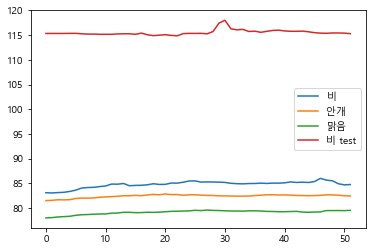

In [119]:
plt.plot(train_rain.mean())
plt.plot(train_sunny.mean())
plt.plot(train_fog.mean())

plt.plot(X_set1[1])
plt.legend(['비','안개','맑음','비 test'])


In [98]:
X_set1[0]

array([ 9.40306122,  9.2755102 ,  9.24489796,  9.13265306,  8.65816327,
        9.18367347,  9.09183673,  9.13265306,  9.14795918,  9.08673469,
        9.31632653,  9.39795918,  9.44387755,  9.51020408,  9.41836735,
        9.41326531,  9.38265306,  9.42346939,  9.26020408,  8.46428571,
        9.37755102,  8.68367347,  8.92346939,  8.71938776,  8.80612245,
        8.73469388,  8.73469388,  8.75      ,  8.77040816,  8.66836735,
        8.75510204,  8.73979592,  9.43367347,  8.78061224,  8.64285714,
        8.65306122,  8.39285714,  8.45408163,  8.44897959,  8.55102041,
        8.55102041,  9.03061224,  9.06122449,  9.03061224,  9.06632653,
        9.05102041,  9.6377551 , 11.19387755,  9.07653061, 10.41836735,
        9.03571429,  8.80612245,  8.80612245,  9.41326531])

In [99]:
m_r = train_rain.mean()
m_s = train_sunny.mean()
m_f = train_fog.mean()

In [100]:
pred = []
for row in X_set1:
    dis_rain = np.mean(np.abs(row - m_r))
    dis_sunny = np.mean(np.abs(row - m_s))
    dis_fog = np.mean(np.abs(row - m_f))
    
    min_dis = min(dis_rain, dis_sunny, dis_fog)
    if min_dis == dis_rain:
        pred.append('비')
    elif min_dis == dis_fog:
        pred.append('안개')
    elif min_dis == dis_sunny:
        pred.append('맑음')
        
    else:
        pred.append('None')

In [101]:
np.mean(np.equal(pred, np.array(y_test)))

0.40425531914893614

In [67]:
np.unique(pred)

array(['None', '맑음', '비', '안개'], dtype='<U4')

In [44]:
len(np.mean(train_rain, axis = 1))

84

In [31]:
label1.sunny.unique()

array([0, 1], dtype=int64)

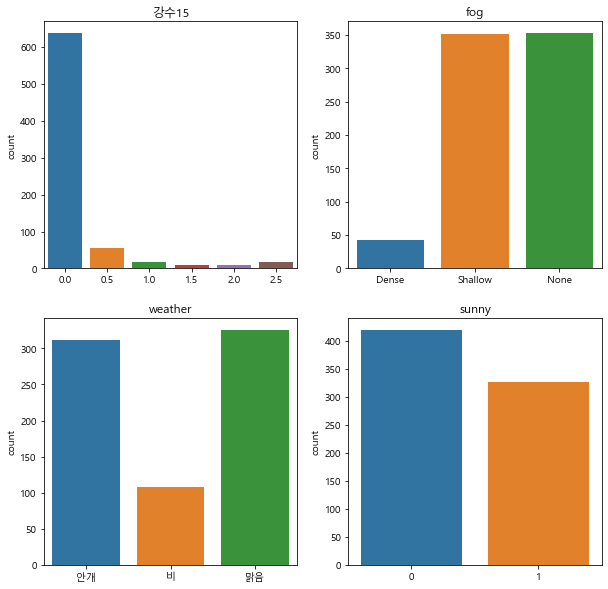

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()

rc('font', family=font_name)
label_col = all_data.columns[3:7]
plt.figure(figsize = (10,10))
for _ , i in enumerate(label_col):
    plt.subplot(2,2, _+1)
    sns.countplot(x = i ,data=total)
    plt.title(i)
    plt.xlabel('')

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X, 'single')